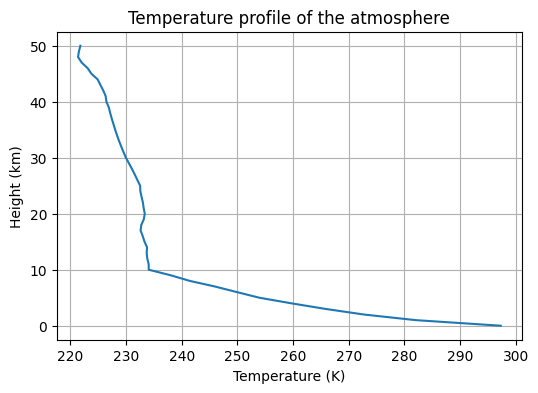

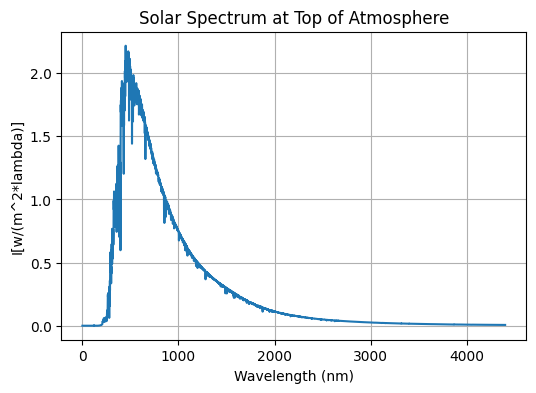

2.9434461495550166 total solar energy at TOA
4400


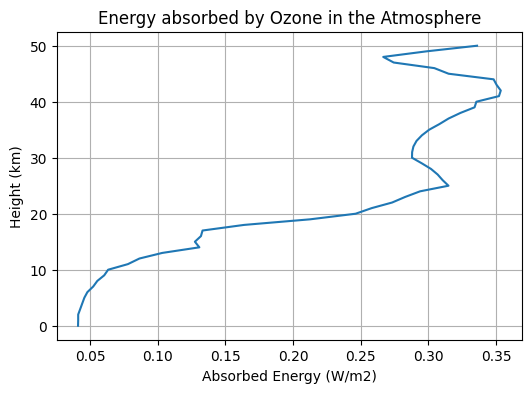

11.156417889862952 total energy absorped by ozone
(89, 51)
(89,)
(89,)
(89, 51)
1029.6952956541625
1029.6952956541625


In [16]:
#2 Stream model
from System_matrix import N_layer_system
from System_solve import solve_N_layer_latent, solve_Temps
from Real_atmosphere import read_atmosphere
from E_in_Ozone import Ozone_absorption_constant_253K_P, Sun_E_bands,E_abs_O
from plotting import plot_profile_atmosphere, plot_flux, plot_sun_spectrum,plot_E_abs_O

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

file="Spectra/Ozone_spectrum.csv"
dz=1000 # layer thickness in m
height=50 # height of atmosphere in km
z_interp, O3_interp, T_real, p_real, n_air,H2Oppm = read_atmosphere("Standard_Atmospheres/mid_lat_summer.csv",height,dz)
S=1370
A=0.3
#make bands
Bandends=[220,1100]
Bandwidth=10
band_interval_O, absorptivity_interval_mean = Ozone_absorption_constant_253K_P(file,Bandends, Bandwidth)
E_bands = Sun_E_bands(band_interval_O)
E_bands=np.array(E_bands)

E_abs_height,E_layer_abs_interval=E_abs_O(E_bands/4, absorptivity_interval_mean, band_interval_O, O3_interp, z_interp, dz=1000)

#epsilon for each layer, and latent heat flux. 
###Check N layers is equal to len(eps) and len(L)
### Manually

E_surface=S*(1-A)/4-np.sum(E_abs_height) #Total energy surface.
RL=0.3
EL=E_surface*RL #Latent heat flux % of surface energy

eps=np.array([1,0.24720534,0.20913575,0.1544279,0.1117628,0.08227208,0.06330484,0.04956816,0.0401921,0.03226433,0.02686877])*1.7
top_layers=np.zeros(40) #No latent heat in the top 30 layers
L= np.array([0,EL*0.28,EL*0.20,EL*0.18,EL*0.13,EL*0.08,EL*0.06,EL*0.04,EL*0.02,EL*0.01,0]) #Decreasing energy transfer
L=np.concatenate((L,top_layers))
L= L+E_abs_height #Add the ozone absorption to the latent heat flux
eps_top=top_layers+0.01
eps=np.concatenate((eps,eps_top)) #Make the rest of the layers very thin to radiation.
eps[0]=1

M=N_layer_system(eps)
Q,T=solve_N_layer_latent(E_surface, RL, M, L) # Energy absorbed in each layer in W/m2
Temps=solve_Temps(Q) # Temps in K

plot_profile_atmosphere(Temps,z_interp)


I=plot_sun_spectrum("Spectra/Sun_spectra_TOA_1nm_1.csv")
print(np.sum(I[4000:]),"total solar energy at TOA")
print(len(I))


plot_E_abs_O(E_abs_height,z_interp)
print(np.sum(E_abs_height),"total energy absorped by ozone")

sum_interval=np.zeros(len(E_bands))
E_layer_abs_interval=np.array(E_layer_abs_interval)
print(E_layer_abs_interval.shape)
for i in range(len(E_bands)):
    sum_interval[i]=E_bands[i]-np.sum(E_layer_abs_interval[i,:])

print(band_interval_O.shape)
E_bands=np.array(E_bands)
print(E_bands.shape)
print(E_layer_abs_interval.shape)
print(np.sum(E_bands))
print(np.sum(Sun_E_bands(band_interval_O)))


1364.0024823607612


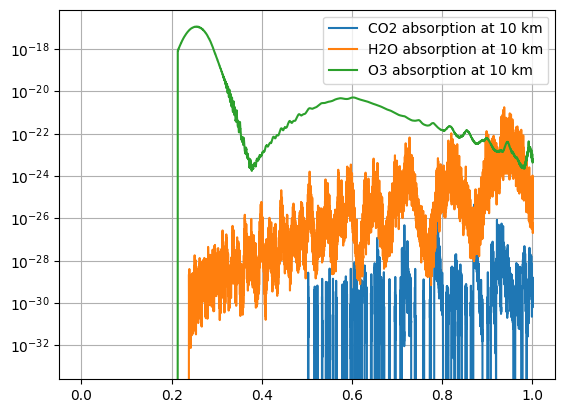

204.4703948123242 total energy absorped in SW
[23.49544534 22.91478731 21.59914384 19.42879097 17.11648541 14.70165807
 12.48390442 10.47319255  8.02642612  4.93232111  3.18722889  2.28200061
  1.71144778  1.37508289  1.24032822  1.20982434  1.23484982  1.30380102
  1.36166272  1.42469694  1.46129032  1.46548172  1.47479986  1.44346422
  1.40737084  1.3522118   1.27657835  1.21171109  1.16169281  1.11651594
  1.07708055  1.04400868  1.01326701  0.99715336  0.98681831  0.98046106
  0.9793819   0.97679609  0.97833552  0.97425614  0.98299392  1.00631928
  1.01179349  1.01882982  0.99957806  0.95446649  0.89443875  0.835634
  0.87333499  1.01125207]
50


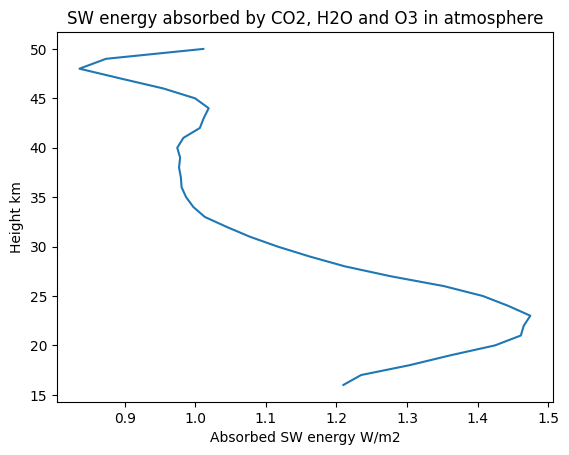

In [98]:
#High res 0,1 nm spectra for CO2 and H2O absorption coefficients in layers
def E_SW_IN_abs(E_SW_Bands,spectrum_CO2,spectrum_H2O,spectrum_O3, n_CO2_mid, n_H2O_mid,n_O3_mid, dz,theta): #dz because current data i lin.space in height
    ### dz in [cm] n_CO2 [molecule/cm^3], spectrum [cm^2/molecule]
    
    
    tau=np.zeros([len(spectrum_CO2[:,0]),len(spectrum_CO2[0])])
    for i in range(len(spectrum_CO2[:,0])):#Rows are height
        for j in range(len(spectrum_CO2[0])): #Columns are spectra values
            tau[i][j]=(spectrum_CO2[i][j]*n_CO2_mid[i]+spectrum_H2O[i][j]*n_H2O_mid[i]+spectrum_O3[i][j]*n_O3_mid[i])*dz
    
    E_SW_abs=np.zeros(len(spectrum_CO2[:,0]))
    E_SW_IN=E_SW_Bands
    for i in range(len(spectrum_CO2[:,0])): 
        k=len(spectrum_CO2[:,0]) -1 - i #Start from top of atmosphere
        E_SW_abs[k]=np.sum(E_SW_IN*(1-np.exp(-tau[k,:]/theta)))
        E_SW_IN=E_SW_IN*np.exp(-tau[k,:]/theta) #transmitted energy to next layer down
            
    return tau,E_SW_abs

z_interp, O3_interp, T_real, p_real, n_air,H2Oppm= read_atmosphere(file="Standard_Atmospheres/US_standard.csv",height=50,dz=1000)
mid_air=n_air[:-1]+np.diff(n_air)/2
mid_H2Oppm=H2Oppm[:-1]+np.diff(H2Oppm)/2
mid_preal=p_real[:-1]+np.diff(p_real)/2
mid_Treal=T_real[:-1]+np.diff(T_real)/2
CO2ppm=np.ones(len(mid_H2Oppm))*400
mid_O3=O3_interp[:-1]+np.diff(O3_interp)/2#Already molecules/m^3

n_H2O_mid=mid_air*mid_H2Oppm*1e-6*1e-6 #molecule/cm3
n_O3_mid=mid_O3*1e-6 #molecule/cm3
n_CO2_mid=mid_air*CO2ppm*1e-6*1e-6 #molecule/cm3


CO2_SW_spec=np.loadtxt("Spectra/CO2_SW_alpha_layer_0.1nm_0-50km_US.csv", delimiter=",")
H2O_SW_spec=np.loadtxt("Spectra/H2O_SW_alpha_layer_0.1nm_0-50km_US.csv", delimiter=",")
O3_SW_spec_hitran=np.loadtxt("Spectra/O3_SW_alpha_layer_0.1nm_0-50km_US.csv", delimiter=",")
O3_SW_1_1100nm=np.loadtxt("Spectra/Ozone_spectrum_0.1nm_1-1100nm.csv", delimiter=",")
O3_SW_spec=O3_SW_spec_hitran+O3_SW_1_1100nm[:,1]  #Concatenate O3_spec
SW_bands=np.linspace(0.001, 4.4, 43991) # Wavelength grid from 0.001 to 4.4 um with 43991 points. 0.1 nm resolution
E_SW =np.loadtxt("Spectra/Sun_spectra_TOA_0.1nm_1-4400nm_bands_energy.csv", delimiter=",")
E_SW_bands_m=E_SW
E_SW_bands=np.array(E_SW_bands_m).flatten()
E_SW_bands=E_SW_bands #W/m2 per 0.1 nm band 
dz=1000*100 #dz in cm
theta=np.cos(45*np.pi/180) #degrees zenith angle

print(np.sum(E_SW_bands))

tau_tot,E_abs_height_SW=E_SW_IN_abs(E_SW_bands, CO2_SW_spec, H2O_SW_spec,O3_SW_spec, n_CO2_mid, n_H2O_mid,n_O3_mid, dz, theta) #dz in cm

plt.plot(SW_bands[0:10000],CO2_SW_spec[0,0:10000], label='CO2 absorption at 10 km')
plt.plot(SW_bands[0:10000],H2O_SW_spec[0,0:10000], label='H2O absorption at 10 km')
plt.plot(SW_bands[0:10000],O3_SW_spec[0,0:10000], label='O3 absorption at 10 km')
plt.legend()
plt.grid()
#Concatenate O3_spec
plt.yscale('log')
plt.show()

plt.plot(E_abs_height_SW[15:],z_interp[16:]/1000)
plt.xlabel("Absorbed SW energy W/m2")
plt.ylabel("Height km")
plt.title("SW energy absorbed by CO2, H2O and O3 in atmosphere")
print(np.sum(E_abs_height_SW),"total energy absorped in SW")

#save E_abs_height_SW to csv
np.savetxt("E_abs_height_SW_5_n=50_1to50km_US_standard.csv", E_abs_height_SW, delimiter=",")

print(E_abs_height_SW)
print(len(tau_tot))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
[1.0000e-03 1.1000e-03 1.2000e-03 ... 4.3998e+00 4.3999e+00 4.4000e+00]
172398.73421611643
48.46939960740842 total energy absorped by ozone with Rayleigh
48.23107546548543 total energy absorped by ozone in each layer with Rayleigh


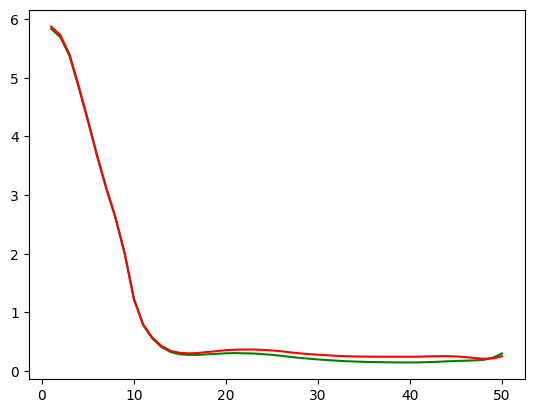

In [ ]:
#REFLECTIONS optical depth
def tau_Ray(lam,z): #lam in um and #z_interp in km
    
    tau_R=np.zeros([len(z_interp)-1,len(lam)])
    for i in range(len(lam)): #Centers
        tau_tot=0.0088 * lam[i]**(-4.15 + 0.2*lam[i]) * np.exp(-0.1188*z - 0.00116*z**2)
        tau_R[:,i]=tau_tot[:-1]-tau_tot[1:]
        #print(tau_tot[0])
    return tau_R #bottom to top

    
def E_abs_Ozone_R(E_bands, tau_tot,tau_R, SW_bands, z_interp,mu=1/np.cos(45*np.pi/180)):
    #They have matched wavelength
    E_layer_abs = np.zeros(len(z_interp)-1)
    E_abs_spec=[]
    E_scattered_up=np.zeros_like(tau_R)
    for i in range(len(SW_bands)): #Calc energy absorped in each layer, with dz
        
        E_in=E_bands[i]
        E_layer_abs_interval=[]
        for j in range(len(z_interp)-1):
            j=len(z_interp)-2 - j #Start from top of atmosphere
            tau_abs=tau_tot[j,i]
            tau=tau_R[-(j+1),i]+tau_abs
            E_layer_abs_interval.append(E_in*(1-np.exp(-tau_abs*mu)))
            E_in=E_in*np.exp(-tau*mu)+E_in*(1-np.exp(-tau_R[-(j+1),i]*mu))/2 #transmitted energy +2 half of scattered energy

            E_scattered_up[j,i]=E_in*(1-np.exp(-tau_R[-(j+1),i]*mu))/2

        E_layer_abs=E_layer_abs+E_layer_abs_interval[::-1] #reverse the order to match altitude
        E_abs_spec.append(E_layer_abs_interval[::-1])
    E_abs_spec=np.array(E_abs_spec)
    #Add first reflection
    #mu_up is equal in all directions
    mu_up=1.66
    E_abs_tot_R=np.zeros(len(z_interp)-1)
    for i in range(len(SW_bands)):

        E_abs_R=np.zeros(len(z_interp)-1)
        
        E_in_R=E_scattered_up[0,i]
        for j in range(len(E_abs_R)):
            E_abs_R[j]=E_in_R*(1-np.exp(-tau_tot[j,i]*mu_up))
            E_in_R=E_in_R*np.exp(-tau_tot[j,i]*mu_up)+E_scattered_up[j,i]*np.exp(-tau_tot[j,i]*mu_up)
            
        E_abs_tot_R+=E_abs_R
    
    E_R1_tot_abs=E_layer_abs+E_abs_tot_R
    return E_R1_tot_abs, E_layer_abs, E_abs_tot_R


tau_R=tau_Ray(SW_bands,z_interp*0.001)
print(z_interp*0.001)
print(SW_bands)
print(np.mean(tau_R[3,:]))
E_R1_tot_abs, E_layer_abs,E_abs_tot_R=E_abs_Ozone_R(E_SW_bands/4, tau_tot, tau_R, SW_bands, z_interp)

print(np.sum(E_R1_tot_abs),"total energy absorped by ozone with Rayleigh")
print(np.sum(E_layer_abs),"total energy absorped by ozone in each layer with Rayleigh")


plt.plot(z_interp[1:]/1000.0,E_R1_tot_abs,label='With Rayleigh',color='green')
plt.yscale('log')
#plt.plot(z_interp[1:]/1000.0,E_abs_tot_R,label='Without Rayleigh',color='orange')

plt.plot(z_interp[1:]/1000.0,E_abs_height_SW/4,label='Total SW absorption',color='red')


6.429017606017811
0.201
[5.87386133 5.72869683 5.39978596 4.85719774 4.27912135 3.67541452
 3.1209761  2.61829814 2.00660653 1.23308028 0.79680722 0.57050015
 0.42786195 0.34377072 0.31008206 0.30245609 0.30871246 0.32595026
 0.34041568 0.35617424 0.36532258 0.36637043 0.36869997 0.36086606
 0.35184271 0.33805295 0.31914459 0.30292777 0.2904232  0.27912899
 0.26927014 0.26100217 0.25331675 0.24928834 0.24670458 0.24511527
 0.24484548 0.24419902 0.24458388 0.24356403 0.24574848 0.25157982
 0.25294837 0.25470745 0.24989451 0.23861662 0.22360969 0.2089085
 0.21833375 0.25281302]


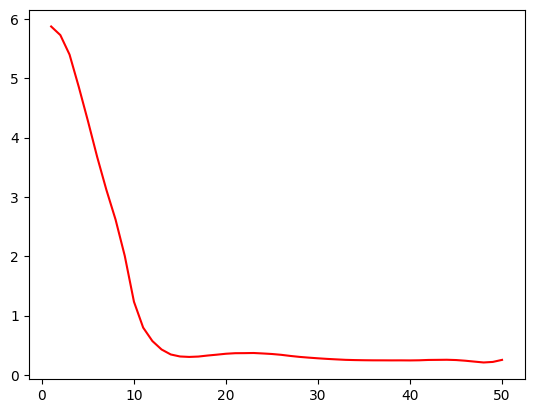

In [106]:
#plt.plot(z_interp[1:]/1000.0,E_R1_tot_abs,label='With Rayleigh',color='green')
#plt.plot(z_interp[1:]/1000.0,E_abs_tot_R,label='Without Rayleigh',color='orange')
#plt.plot(z_interp[1:]/1000.0,E_layer_abs,label='Single scatter',color='blue')
plt.plot(z_interp[1:]/1000.0,E_abs_height_SW/4,label='Total SW absorption',color='red')


print(np.sum(tau_R[:,2000]))
print(SW_bands[2000])

print(E_abs_height_SW/4)

In [93]:
import numpy as np

def E_abs_Ozone_single_scatter(
    E_bands,               # [nband] TOA direct solar energy per band (per horizontal area)
    mean_spec,             # [nband] ozone cross-section  m^2/molecule
    O3_profile,            # [nlay] molecules/m^3   (bottom -> top)
    dz_m,                  # scalar layer thickness [m]
    tau_R_vert,            # [nband, nlay] Rayleigh **vertical** optical depth per layer
    mu0=np.cos(np.deg2rad(45.0)),  # cos(SZA) for direct beam
    mu_d=0.66,             # effective diffuse mean cosine (Eddington-like)
    surface_albedo=0.1,    # scalar or [nband]   
    g_asym=None            # [nband, nlay] asymmetry factor; if None, uses Rayleigh ~ 0 ⇒ 50/50 split
):
    """
    Returns:
      E_abs_total : [nlay] ozone absorption (direct + single-scattered diffuse + one surface bounce)
      E_abs_down  : [nlay] ozone absorption from direct-beam only (no scatter/bounce)
    Notes:
      * O3_profile is bottom->top. Code sweeps top->bottom for direct, bottom->top for the upward diffuse.
      * tau_R_vert is **vertical** per layer. Slant factors are applied internally.
      * Rayleigh is treated as pure scattering (no heating), absorption only from ozone.
    """
    O3 = np.asarray(O3_profile, dtype=float)          # bottom->top
    nlay = O3.size
    nband = len(E_bands)

    sigma = np.asarray(mean_spec, dtype=float)

    # ozone vertical tau per layer: tau_abs_vert[i, j] = sigma[i] * O3[j] * dz
    tau_abs_vert = np.outer(sigma, O3 * dz_m)         # [nband, nlay]

    # check albedo broadcast
    if np.isscalar(surface_albedo):
        A = np.full(nband, float(surface_albedo))
    else:
        A = np.asarray(surface_albedo, dtype=float); assert len(A) == nband

    # asymmetry factor (Rayleigh ~ 0 ⇒ 50/50 up/down)
    if g_asym is None:
        g_asym = np.zeros((nband, nlay), dtype=float)
    else:
        g_asym = np.asarray(g_asym, dtype=float); assert g_asym.shape == (nband, nlay)

    E_abs_down  = np.zeros(nlay)   # direct-beam ozone absorption only
    E_abs_total = np.zeros(nlay)   # total ozone absorption (add diffuse + bounce later)

    for i in range(nband):
        # per-layer slant optical depths
        tau_abs_s = tau_abs_vert[i] / mu0
        tau_scat_v = tau_R_vert[i]               # Rayleigh (vertical)
        tau_scat_s = tau_scat_v / mu0            # Rayleigh (slant) for direct beam
        tau_ext_s  = tau_abs_s + tau_scat_s      # extinction for direct beam

        # ---- DOWNWARD SWEEP (TOP -> BOTTOM) ----
        F_dir = float(E_bands[i])                # direct beam at TOA
        F_diff_down = 0.0                        # accumulated downward diffuse at current layer bottom
        # We'll store upward diffuse sources generated in each layer to propagate later
        S_up = np.zeros(nlay)                    # upward diffuse source created in each layer (from direct scattering)

        for j in range(nlay-1, -1, -1):          # j: top..bottom (index nlay-1 -> 0)
            # Direct-beam loss in this layer
            F_out = F_dir * np.exp(-tau_ext_s[j])
            loss  = F_dir - F_out                               # total removed from direct
            # Partition direct-beam loss into absorption vs scattering
            f_abs = tau_abs_s[j] / (tau_ext_s[j] + 1e-30)
            A_dir = loss * f_abs                                # ozone heating from direct beam
            S_dir = loss - A_dir                                # becomes diffuse (Rayleigh)

            # up/down split for scattered power (single-scatter)
            eta_f = 0.5 * (1.0 + g_asym[i, j])                 # forward fraction
            eta_b = 1.0 - eta_f                                 # backward fraction
            S_down = S_dir * eta_f
            S_up[j] = S_dir * eta_b

            # Handle existing downward diffuse inside this layer (absorb + transmit)
            if F_diff_down > 0.0:
                # absorption of diffuse within layer (vertical tau scaled to diffuse path)
                Tdiff_abs = np.exp(-tau_abs_vert[i, j] * (mu0 / mu_d))
                A_diff_d  = F_diff_down * (1.0 - Tdiff_abs)
                E_abs_total[j] += A_diff_d
                # full extinction on diffuse (abs + scat)
                Tdiff_ext = np.exp(-(tau_abs_vert[i, j] + tau_scat_v[j]) * (mu0 / mu_d))
                F_diff_down = F_diff_down * Tdiff_ext

            # Add the direct-beam absorption for this layer
            E_abs_down[j] += A_dir

            # At layer bottom, add newly created downward diffuse
            F_diff_down += S_down
            # Advance direct beam
            F_dir = F_out

        # Flux at surface (direct + downward diffuse)
        F_surf = F_dir + F_diff_down

        # ---- SURFACE REFLECTION (single bounce) ----
        F_up = A[i] * F_surf   # becomes upward diffuse

        # ---- UPWARD SWEEP (BOTTOM -> TOP) ----
        for j in range(0, nlay):      # bottom..top
            # Add the upward diffuse source created in this layer from direct-beam scattering
            F_up += S_up[j]

            if F_up > 0.0:
                # ozone absorption of upward diffuse in this layer
                Tdiff_abs = np.exp(-tau_abs_vert[i, j] * (mu0 / mu_d))
                A_diff_u  = F_up * (1.0 - Tdiff_abs)
                E_abs_total[j] += A_diff_u

                # transmit remaining upward with extinction (abs + scat)
                Tdiff_ext = np.exp(-(tau_abs_vert[i, j] + tau_scat_v[j]) * (mu0 / mu_d))
                F_up = F_up * Tdiff_ext

    # add direct-beam absorption once
    E_abs_total += E_abs_down
    return E_abs_total, E_abs_down


# Shapes:
# E_bands:       (nband,)
# mean_spec:     (nband,)            # cm^2/molecule  -> set sigma_in_cm2=True (default)
# O3_interp:     (nlay,)             # bottom->top
# tau_R_vert:    (nband, nlay)       # vertical Rayleigh per layer
# dz_m: scalar
#tau_R should be 89,51 add 0 coulumn the the end for surface layer
tau_R_2=np.concatenate([tau_R,np.zeros((tau_R.shape[0],1))],axis=1)

print(tau_R.shape)
E_abs_to_chat, E_abs_down = E_abs_Ozone_single_scatter(
    E_SW_bands/4, absorptivity_interval_mean, O3_interp, dz_m=1000.0, tau_R_vert=tau_R_2,
    mu0=np.cos(np.deg2rad(45.0)), mu_d=0.66, surface_albedo=0.3,
    g_asym=None  # or pass g_asym with aerosols/clouds
)
print(np.sum(E_abs_to_chat),"total energy absorped by ozone with single scatter")
print(np.sum(E_abs_down),"total energy absorped by ozone with direct beam only")

plt.plot(E_abs_to_chat,label="Total absorption with single scatter,ChatGPT")
plt.plot(E_R1_tot_abs,label='With Rayleigh')
plt.legend()


(50, 43991)


ValueError: operands could not be broadcast together with shapes (51,) (43992,) 

In [ ]:
tau_R_2=np.concatenate([tau_R,np.zeros((tau_R.shape[0],1))],axis=1)

print(tau_R.shape)
E_abs_to_chat, E_abs_down = E_abs_Ozone_single_scatter(
    E_SW_bands/4, abs, O3_interp, dz_m=1000.0, tau_R_vert=tau_R_2,
    mu0=np.cos(np.deg2rad(45.0)), mu_d=0.66, surface_albedo=0.0,
    g_asym=None  # or pass g_asym with aerosols/clouds
)
print(np.sum(E_abs_to_chat),"total energy absorped by ozone with single scatter")
print(np.sum(E_abs_down),"total energy absorped by ozone with direct beam only")

plt.plot(E_abs_to_chat,label="Total absorption with single scatter,ChatGPT")
plt.plot(E_R1_tot_abs,label='With Rayleigh')
plt.legend()
